In [72]:
import pandas as pd
import numpy as np
import csv
import random

from scipy import stats, integrate
import matplotlib.pyplot as plt
import re
import nltk
from nltk.probability import FreqDist

import seaborn as sns
sns.set(color_codes=True)

import scrapeMyProf as smp
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Scraping things to do
* Add review id
looks like <tr id="27765702" class = "">

Ultimate goal
* Look up a professor, predict average overall/difficulty based on department/gender/school. Get the deviation from that amount. Purpose: evaluate individual teaching in the correct playing field.
* Look up school, show deviation of departments from predictions based on department.
* What words or phrases predict a good/bad professor (for men/women/department). Purpose: to better understand reaction to teaching, retention for schools.

Done, need to make way to repeat analysis
* Count of male/female/unknown
* Number of reviews per prof
* Number of reviews per prof per year (will need to figure out date coding)
* Avg num words by gender (per review)
* Lex Diversity by gender (per review)
* Get school number of review_df

Things to do next
* Figure out how to use one of the nltk classifiers
* Work on explaining why women have fewer reviews than men (start with reviews by year!)
* Difficulty vs Overall for men vs. women (linear regression)
* Note that I need to get different schools to compare
* Can relate avg num words to positive or negative review
* Pull out stop words & do prev two again
* Ratings vs words vs gender (cluster words by ratings and gender??)
* Count of words that are all uppercase (would have to be done before clean_text

In [2]:
# Current colHeader
colHeader = ['accessible',
                         'amazing',
                         'caring',
                         'class',
                         'criteria',
                         'date',
                         'difficulty',
                         'extra',
                         'feedback',
                         'few',
                         'gender',
                         'grade',
                         'group',
                         'hilarious',
                         'homework',
                         'inspirational',
                         'lecture',
                         'overall',
                         'papers',
                         'participation',
                         'profFirst',
                         'profID',
                         'quiz',
                         'read',
                         'respected',
                         'skip',
                         'test',
                         'textInfo',
                         'tough']

In [6]:
review_df = smp.cleanAddGender_csv('smp_data/Jan26_1237',colHeader)

In [7]:
groupProf_df = smp.groupProf_df(review_df,'smp_data/Jan26_1237')

In [8]:
# this gives total numbers of reviews
review_df['genderBest'].value_counts()

male       27702
female     16528
unknown      183
Name: genderBest, dtype: int64

In [9]:
# avg reviewcount for women vs. men
# what explains this
groupProf_df[['genderBest','reviewcount']].groupby('genderBest').mean()

,reviewcount
genderBest,
female,8.703528
male,11.480315
unknown,3.734694


In [130]:
review_df['wordcount']=review_df['cleanText'].apply(len)

In [138]:
#lexical diversity for each review
def lexDiversity(text):
    if len(text)==0:
        ld = 0
    else:
        ld = len(text)/len(set(text))
    return ld
review_df['lexDiversity']=review_df['cleanText'].apply(lexDiversity)

In [143]:
review_df[['genderBest','wordcount','lexDiversity','overall','difficulty']].groupby('genderBest').mean()

,wordcount,lexDiversity,overall,difficulty
genderBest,,,,
female,219.577928,9.355438,3.757321,2.821091
male,218.722222,9.305363,3.728861,2.938479
unknown,201.475410,8.652069,3.560109,2.901639


In [178]:
overallF = review_df[['overall','difficulty','wordcount','lexDiversity']][review_df['genderBest']=='female'].groupby('overall').mean()

In [179]:
overallM = review_df[['overall','difficulty','wordcount','lexDiversity']][review_df['genderBest']=='male'].groupby('overall').mean()

In [180]:
overallF

,difficulty,wordcount,lexDiversity
overall,,,
1.0,4.078431,216.609804,9.298321
1.5,3.759784,235.916329,10.024470
2.0,3.597129,229.960766,9.764213
2.5,3.340741,243.483951,10.289448
3.0,3.205390,232.072491,9.848030
3.5,2.877766,235.965227,9.970601
4.0,2.667014,225.466701,9.559474
4.5,2.528253,216.706764,9.239160
5.0,2.275535,207.911587,8.893528


In [181]:
overallM

,difficulty,wordcount,lexDiversity
overall,,,
1.0,4.216940,212.504594,9.110791
1.5,3.927162,225.683612,9.610457
2.0,3.760805,230.266430,9.777717
2.5,3.586567,237.591791,10.016666
3.0,3.234833,233.179916,9.847413
3.5,2.980263,238.075658,10.013213
4.0,2.765951,227.907115,9.642987
4.5,2.638081,223.955669,9.494896
5.0,2.350455,202.145308,8.668114


In [147]:
reviewMF_df = review_df[review_df['genderBest']!='unknown']
groupProfMF_df = groupProf_df[groupProf_df['genderBest']!='unknown']

In [176]:
keywords = list({
    'tough':'Tough Grader','feedback':'Gives good feedback','respected':'Respected','read':'Get ready to read',
    'participation':'Participation matters','skip':'Skip class? You won\'t pass.','homework':'LOTS OF HOMEWORK',
    'inspirational':'Inspirational','quiz':'BEWARE OF POP QUIZZES','accessible':'ACCESSIBLE OUTSIDE CLASS',
    'papers':'SO MANY PAPERS','criteria':'Clear grading criteria','hilarious':'Hilarious',
    'test':'TEST HEAVY','few':'GRADED BY FEW THINGS','amazing':'Amazing lectures','caring':'Caring',
    'extra':'EXTRA CREDIT','group':'GROUP PROJECTS','lecture':'LECTURE HEAVY'
    }.keys())

# fillna on just the keyword columns
review_df[keywords] = review_df[keywords].fillna(0)

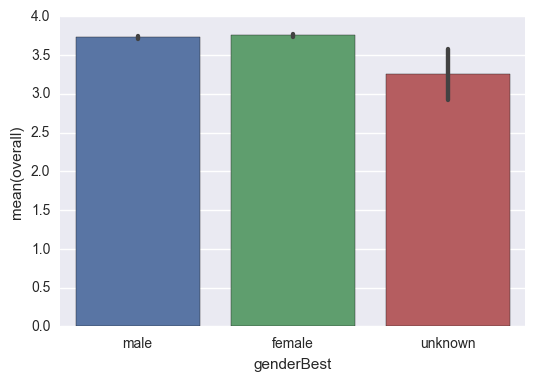

In [105]:
#overall scores by gender
sns.barplot(x="genderBest", y="overall", data=review_df);

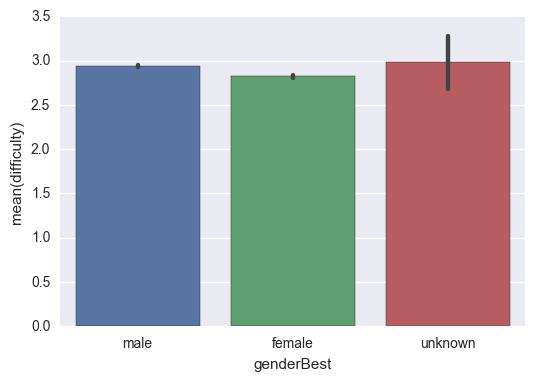

In [64]:
#gender scores by prof
sns.barplot(x="genderBest", y="difficulty", data=review_df);

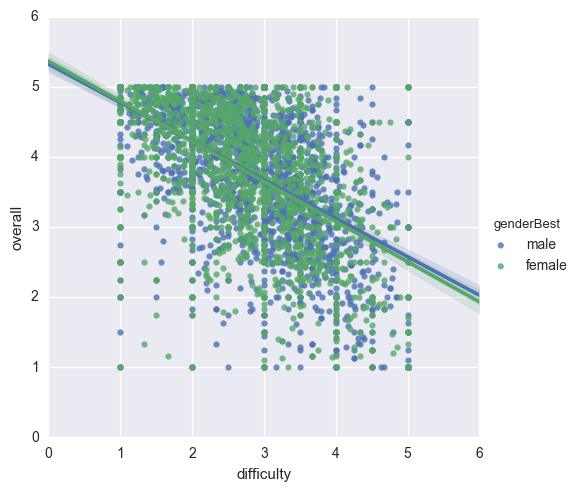

In [153]:
sns.lmplot(x='difficulty',y='overall', hue='genderBest',data=groupProfMF_df);

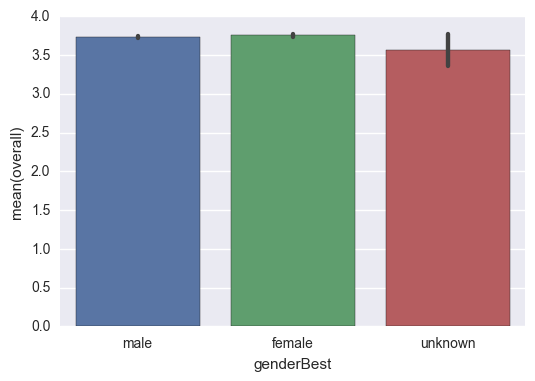

In [182]:
sns.barplot(x="genderBest", y="overall", data=review_df);

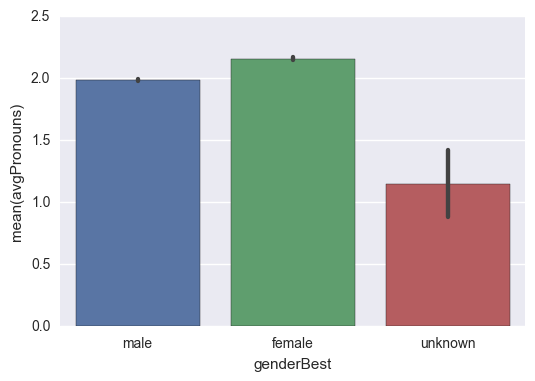

In [115]:
# Average pronoun use by Gender
sns.barplot(x="genderBest", y="avgPronouns", data=review_df);

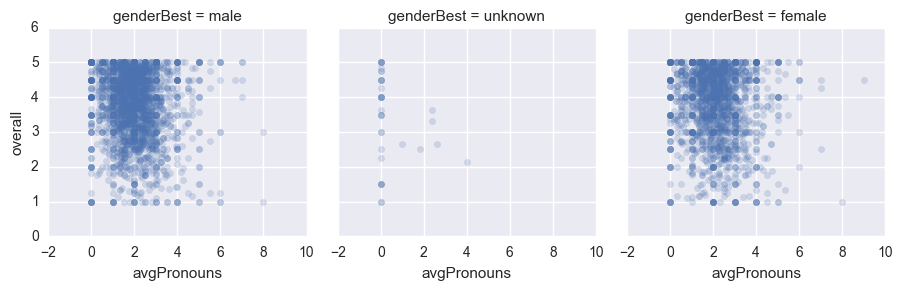

In [125]:
g = sns.FacetGrid(profGrouping, col="genderBest")
g.map(plt.scatter, "avgPronouns", "overall", alpha=.2)
g.add_legend();

In [11]:
review_df[review_df['overall']==3.0]['overall']

7        3.0
20       3.0
33       3.0
47       3.0
48       3.0
64       3.0
72       3.0
80       3.0
85       3.0
95       3.0
106      3.0
107      3.0
115      3.0
126      3.0
129      3.0
131      3.0
139      3.0
151      3.0
155      3.0
157      3.0
159      3.0
172      3.0
198      3.0
199      3.0
234      3.0
254      3.0
291      3.0
295      3.0
302      3.0
309      3.0
        ... 
43984    3.0
44001    3.0
44004    3.0
44008    3.0
44010    3.0
44045    3.0
44055    3.0
44061    3.0
44063    3.0
44068    3.0
44082    3.0
44090    3.0
44102    3.0
44105    3.0
44121    3.0
44145    3.0
44154    3.0
44191    3.0
44196    3.0
44216    3.0
44258    3.0
44266    3.0
44279    3.0
44280    3.0
44293    3.0
44297    3.0
44339    3.0
44364    3.0
44400    3.0
44411    3.0
Name: overall, dtype: float64

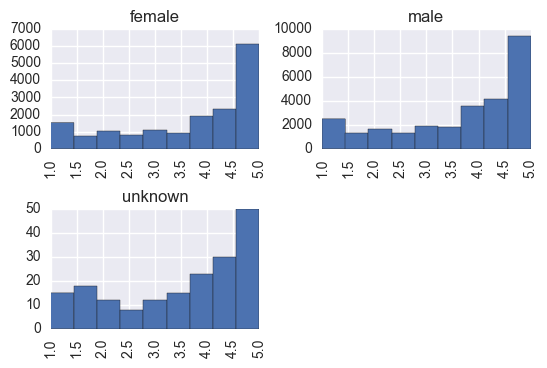

In [15]:
review_df.hist(by='genderBest',column = 'overall',bins = 9)
plt.show()

In [16]:
def content(text):
    stopwords = nltk.corpus.stopwords.words('english')
    content = [word for word in text if word.lower() not in stopwords]
    return content

def content_fraction(text):
    contents = content(text)
    return len(contents)/len(text)

In [17]:
genderText = review_df[['genderBest','cleanText']].groupby('genderBest').sum().reset_index()


In [193]:
genderText

,genderBest,cleanText
0,female,eve is an awesome ta shes super helpful and wa...
1,male,pros fair tests very thorough when answering q...
2,unknown,very helpful always available for helpeasy cla...


In [206]:
femaleTokenize=nltk.word_tokenize(genderText['cleanText'][0])

In [211]:
content_fraction(femaleTokenize)

0.508183049205908

In [212]:
maleTokenize =nltk.word_tokenize(genderText['cleanText'][1])

In [213]:
content_fraction(maleTokenize)

0.5118588329086172

In [219]:
femaleContent = content(femaleTokenize)
femaleDist = FreqDist(femaleContent)
femaleVocab = list(femaleDist.keys())

In [220]:
femaleDist.most_common(50)

[('class', 14970),
 ('teacher', 4416),
 ('take', 4223),
 ('easy', 3938),
 ('really', 3424),
 ('tests', 3381),
 ('shes', 2646),
 ('get', 2516),
 ('good', 2337),
 ('hard', 2263),
 ('great', 2206),
 ('go', 2169),
 ('dont', 2110),
 ('students', 2081),
 ('would', 2053),
 ('professor', 1999),
 ('lot', 1985),
 ('study', 1974),
 ('help', 1933),
 ('helpful', 1858),
 ('lectures', 1792),
 ('nice', 1783),
 ('material', 1737),
 ('interesting', 1736),
 ('one', 1720),
 ('test', 1680),
 ('gives', 1668),
 ('like', 1567),
 ('work', 1557),
 ('notes', 1546),
 ('makes', 1521),
 ('make', 1440),
 ('well', 1410),
 ('grade', 1367),
 ('book', 1365),
 ('time', 1306),
 ('extra', 1300),
 ('ever', 1291),
 ('read', 1283),
 ('questions', 1274),
 ('quizzes', 1269),
 ('best', 1267),
 ('recommend', 1255),
 ('much', 1242),
 ('every', 1215),
 ('always', 1189),
 ('credit', 1176),
 ('also', 1174),
 ('doesnt', 1132),
 ('know', 1096)]

In [221]:
maleContent = content(maleTokenize)
maleDist = FreqDist(maleContent)
maleVocab = list(maleDist.keys())

In [222]:
maleDist.most_common(50)

[('class', 24645),
 ('take', 6908),
 ('teacher', 6539),
 ('tests', 6538),
 ('easy', 6012),
 ('really', 5810),
 ('hes', 4469),
 ('get', 4394),
 ('hard', 4368),
 ('professor', 4318),
 ('good', 4224),
 ('go', 4182),
 ('great', 3858),
 ('lectures', 3660),
 ('dont', 3615),
 ('guy', 3581),
 ('students', 3327),
 ('study', 3256),
 ('help', 3186),
 ('would', 3155),
 ('material', 3135),
 ('test', 3127),
 ('interesting', 3053),
 ('lot', 3012),
 ('one', 2768),
 ('notes', 2558),
 ('like', 2494),
 ('book', 2491),
 ('makes', 2477),
 ('gives', 2436),
 ('well', 2419),
 ('helpful', 2419),
 ('questions', 2371),
 ('make', 2315),
 ('grade', 2300),
 ('best', 2271),
 ('read', 2245),
 ('nice', 2213),
 ('time', 2198),
 ('ever', 2138),
 ('work', 2079),
 ('much', 2020),
 ('quizzes', 2011),
 ('know', 1984),
 ('recommend', 1969),
 ('every', 1918),
 ('understand', 1894),
 ('boring', 1886),
 ('need', 1824),
 ('always', 1823)]

In [56]:
review_df['cleanText'] = review_df['cleanText'] + ' '

In [57]:
allTokenize = nltk.word_tokenize(review_df['cleanText'].sum())

In [58]:
allContent = content(allTokenize)

In [69]:
allDist = FreqDist(allContent)
allFeatures = list(allDist.keys())[:500]

In [39]:
def review_features(review,gender,word_features):
    review_words = set(review)
    features={}
    for word in word_features:
        features['contains(%s)' % word] = (word in review_words)
        features['gender'] = gender
    return features

In [74]:
shortReview = review_df[['cleanText','genderBest','overall']]

In [75]:
reviews = [(review_features(shortReview['cleanText'][i],shortReview['genderBest'][i],allFeatures),shortReview['overall'][i]) for i in range(len(shortReview))]

In [76]:
random.shuffle(reviews)

In [79]:
train_set,test_set = reviews[22206:],reviews[:22206]

In [80]:
classifier = nltk.NaiveBayesClassifier.train(train_set)

In [82]:
print(nltk.classify.accuracy(classifier,test_set))

0.351976943169


In [83]:
classifier.show_most_informative_features(20)

Most Informative Features
                  gender = 'unknown'         1.5 : 2.5    =      4.3 : 1.0
             contains(x) = True              nan : 1.0    =      2.5 : 1.0
             contains(x) = False             nan : 3.5    =      1.2 : 1.0
                  gender = 'female'          2.5 : 3.5    =      1.2 : 1.0
                  gender = 'male'            3.5 : nan    =      1.1 : 1.0
     contains(attracted) = False             nan : 3.5    =      1.0 : 1.0
        contains(fsuand) = False             nan : 3.5    =      1.0 : 1.0
 contains(discriminated) = False             nan : 3.5    =      1.0 : 1.0
        contains(gamble) = False             nan : 3.5    =      1.0 : 1.0
      contains(basement) = False             nan : 3.5    =      1.0 : 1.0
          contains(bunn) = False             nan : 3.5    =      1.0 : 1.0
       contains(whnever) = False             nan : 3.5    =      1.0 : 1.0
        contains(becaus) = False             nan : 3.5    =      1.0 : 1.0

In [47]:
shortReview.apply(lambda x,y:review_features(x,y,allFeatures))

TypeError: ("<lambda>() missing 1 required positional argument: 'y'", 'occurred at index cleanText')

In [167]:

# Compute the correlation matrix
corr = review_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
Back to top 


AttributeError: module 'seaborn' has no attribute 'corrplot'

In [253]:
aggList=dict(zip(keywords,['sum']*len(keywords)))
aggList['genderBest']='count'
aggList

{'accessible': 'sum',
 'amazing': 'sum',
 'caring': 'sum',
 'criteria': 'sum',
 'extra': 'sum',
 'feedback': 'sum',
 'few': 'sum',
 'genderBest': 'count',
 'group': 'sum',
 'hilarious': 'sum',
 'homework': 'sum',
 'inspirational': 'sum',
 'lecture': 'sum',
 'papers': 'sum',
 'participation': 'sum',
 'quiz': 'sum',
 'read': 'sum',
 'respected': 'sum',
 'skip': 'sum',
 'test': 'sum',
 'tough': 'sum'}

In [152]:
# Plot distribution of overall and difficulty against tags
# This function draws a grid of histograms
# numVar is the numeric variable to plot
# variables is a list of indicator variables
def draw_histograms_indic(df, numVar,variables, n_rows, n_cols):
    fig=plt.figure(figsize=(18,16))
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[numVar][df[var_name]==1].hist(bins=8,ax=ax)
        ax.set_title(var_name+" Distribution")
    # fig.tight_layout()  # Improves appearance a bit.
    plt.show()

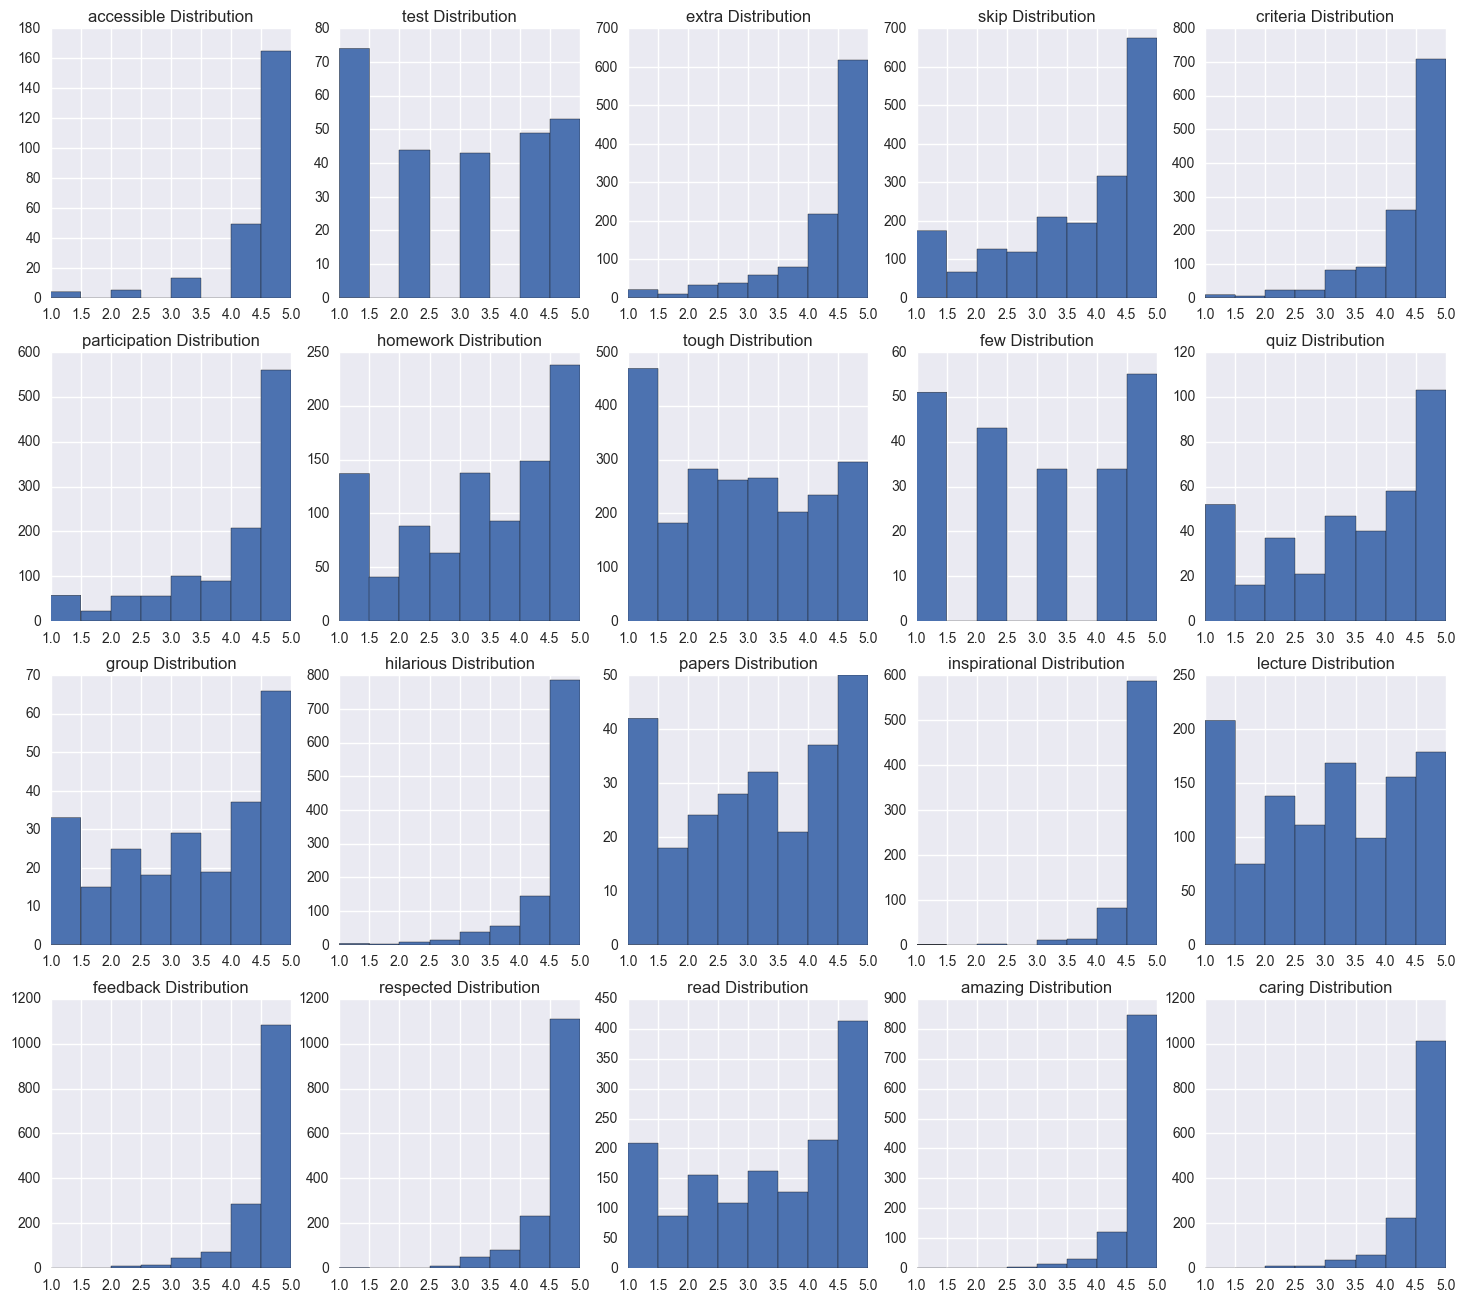

In [150]:
# hist of 'overall' split up by the various tags
draw_histograms_indic(review_df, 'overall',keywords, 4, 5)


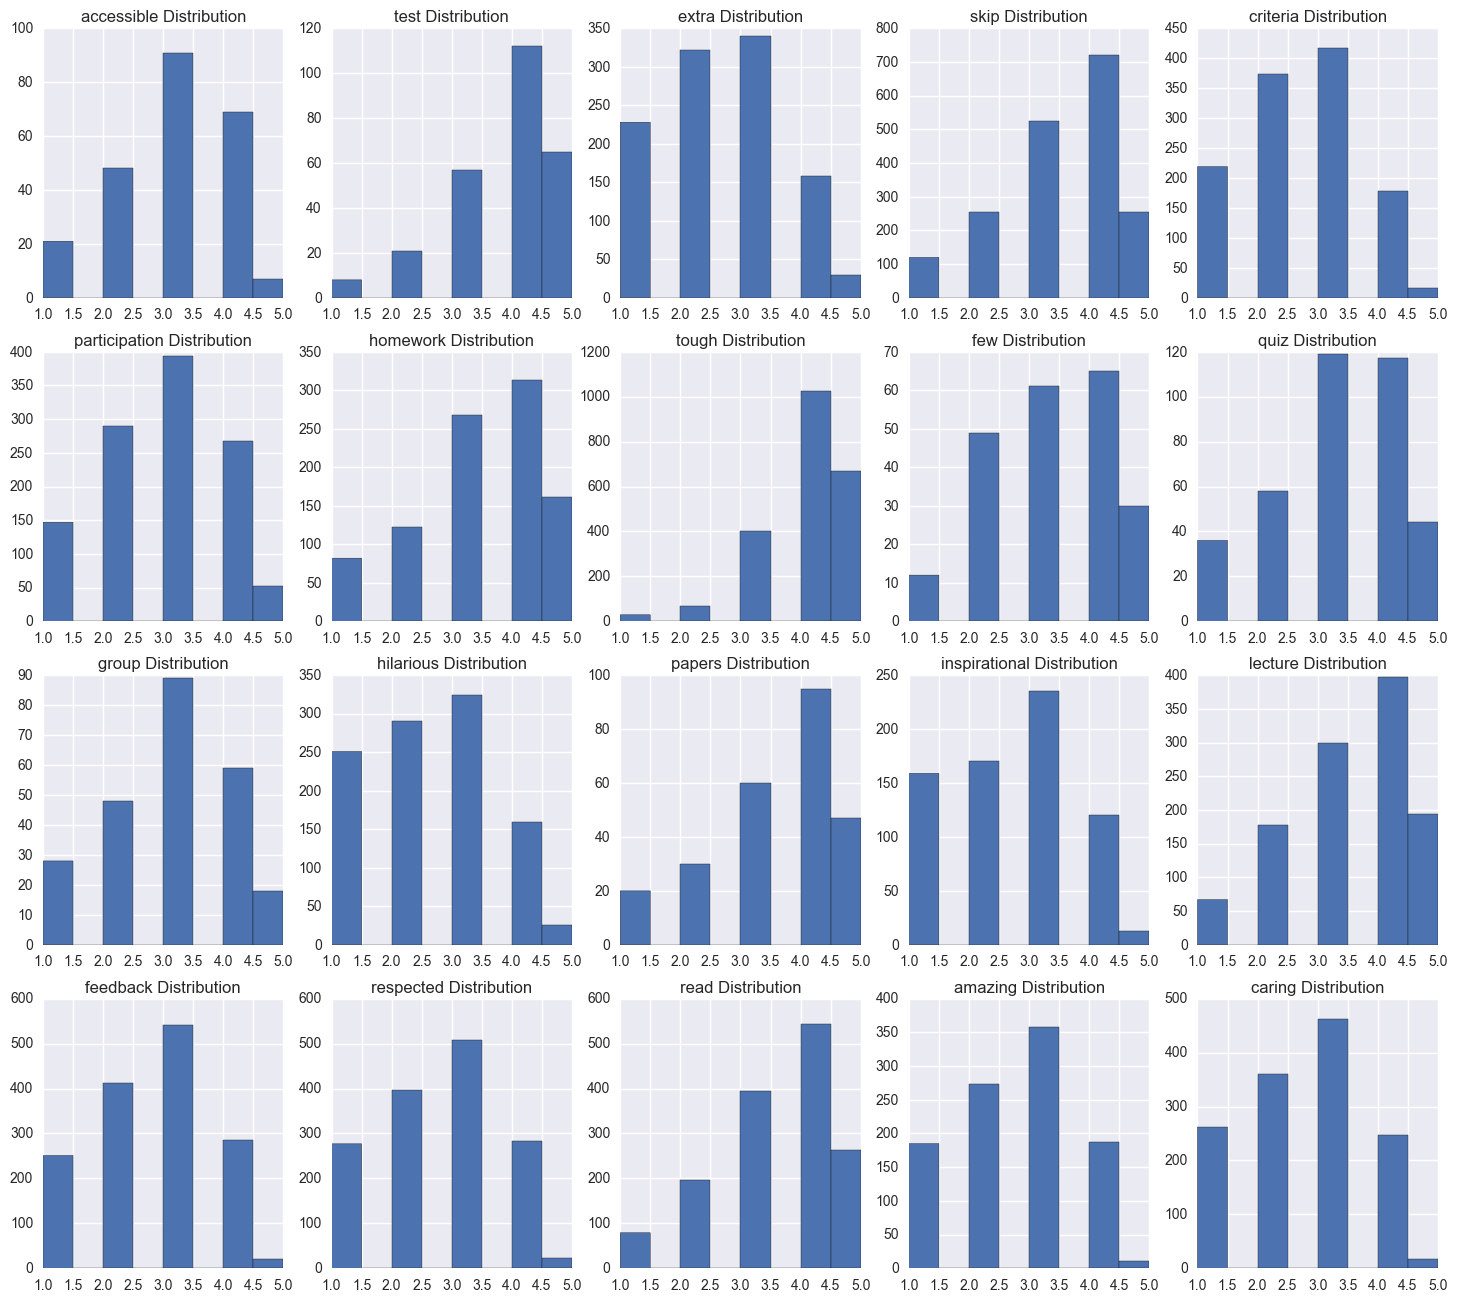

In [151]:
# same histograms but with difficulty -- note that this is much less clear in terms of indicators predicting score
draw_histograms_indic(review_df, 'difficulty',keywords, 4, 5)

In [ ]:
# plot counts of men vs. women for all of these different indicator variables

In [ ]:
# then need to do a count of words